# Twitter Sentiment Analysis
dataset obtained from : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?resource=download

There are two main files:
1) twitter_training.csv as the training set.
2) twitter_validation.csv as the validation set.
3) Top 1 classification accuracy is used as the metric.

Goal: Train a classifier on twitter_training.csv and evaluate its Top-1 accuracy on twitter_validation.csv.

In [75]:
import pandas as pd
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



In [26]:
train_df = pd.read_csv("twitter_training.csv", header=None)
val_df = pd.read_csv("twitter_validation.csv", header=None)

In [28]:
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [53]:
train_df.shape

(74682, 4)

In [30]:
val_df.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [32]:
train_df.columns = ['id', 'topic', 'label', 'text']
val_df.columns = ['id', 'topic', 'label', 'text']


In [38]:
train_df.head()

,id,topic,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [44]:
train_df.dtypes

id        int64
topic    object
label    object
text     object
dtype: object

In [40]:
val_df.head()

,id,topic,label,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [46]:
val_df.dtypes

id        int64
topic    object
label    object
text     object
dtype: object

In [55]:
val_df.shape

(1000, 4)

# data cleaning

In [49]:
print(train_df['text'].isnull().sum())
print(val_df['text'].isnull().sum())

686
0


In [57]:
train_df.dropna(subset=['text'], inplace=True)

In [59]:
print(train_df['text'].isnull().sum())
print(val_df['text'].isnull().sum())

0
0


# Sentiment Analysis using a Logistic Regression Classifier on TF-IDF Features

In [61]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|#\S+", "", text)  
    text = re.sub(f"[{string.punctuation}]", "", text)  
    text = re.sub(r"\d+", "", text)  
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)

In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
val_df['label_enc'] = le.transform(val_df['label']) 

print(le.classes_)  


['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_val = vectorizer.transform(val_df['clean_text'])

y_train = train_df['label_enc']
y_val = val_df['label_enc']


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [71]:
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Top-1 Accuracy: {accuracy:.4f}")


Top-1 Accuracy: 0.8090


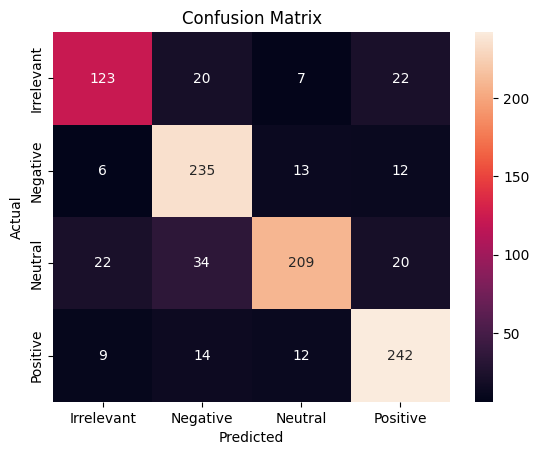

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Trying more models

 Multinomial Naive Bayes

In [91]:

from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_val)

nb_accuracy = accuracy_score(y_val, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")


Naive Bayes Accuracy: 0.7070


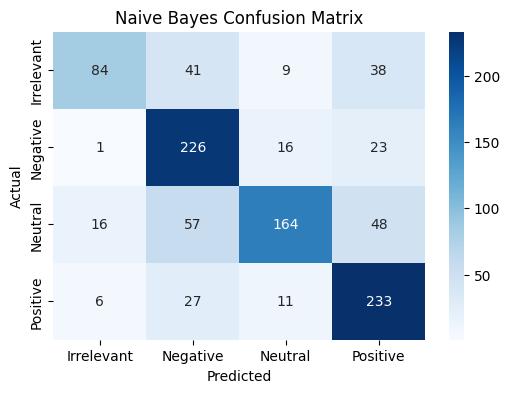

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_nb = confusion_matrix(y_val, nb_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()


Hyperparameter Tuning

In [85]:
from sklearn.model_selection import GridSearchCV

params = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=3)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)


Best Parameters: {'C': 0.1}
Best Cross-Validation Score: 0.4811609013030069


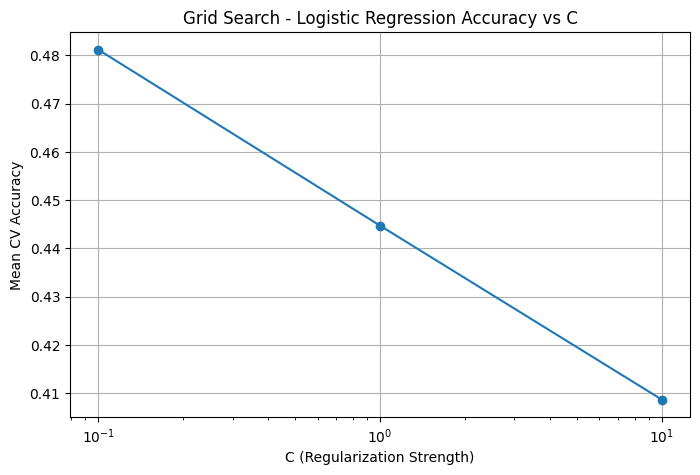

In [95]:
import pandas as pd

results_df = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(results_df["param_C"], results_df["mean_test_score"], marker='o')
plt.xscale('log')  
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Mean CV Accuracy")
plt.title("Grid Search - Logistic Regression Accuracy vs C")
plt.grid(True)
plt.show()


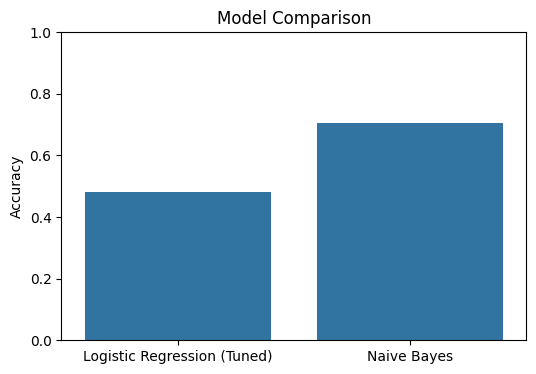

In [97]:
models = ['Logistic Regression (Tuned)', 'Naive Bayes']
scores = [grid.best_score_, nb_accuracy]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=scores)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()
